In this notebook we use multi-class classification models to predict the pitch outcome or result of a given pitcher, which are called events in pybaseball. We do a simple train-test split with validation.

In [1]:
# Importing libraries
import pybaseball
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import f1_score
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

# Enable cache because running pybaseball is a large query
pybaseball.cache.enable()

We consider consecutive sequences of pitches of length pitch_sequence_length. Our objective is to predict the last pitch outcome in the sequence using the previous pitch_sequence_length-1 pitches.

In [2]:
pitch_sequence_length=5

Upload the data.

In [3]:
train_start = '2023-05-01'
train_end = '2023-07-01'

val_start = '2024-05-01'
val_end = '2024-05-05'

test_start = '2025-05-01'
test_end = '2025-05-05'

# Train-test split with validation
train_data = pybaseball.statcast(start_dt=train_start, end_dt=train_end, verbose=True)
val_data = pybaseball.statcast(start_dt=val_start, end_dt=val_end, verbose=True)
test_data = pybaseball.statcast(start_dt=test_start, end_dt=test_end, verbose=True)

print(len(train_data), len(val_data), len(test_data))

This is a large query, it may take a moment to complete


100%|██████████| 62/62 [00:06<00:00,  9.13it/s]


This is a large query, it may take a moment to complete


100%|██████████| 5/5 [00:00<00:00, 12.59it/s]

This is a large query, it may take a moment to complete



100%|██████████| 5/5 [00:00<00:00, 13.14it/s]

242754 19165 18830


In [4]:
# Remove any possible duplicate rows
train_data = train_data.drop_duplicates()
val_data = val_data.drop_duplicates()
test_data = test_data.drop_duplicates()

print(len(train_data), len(val_data), len(test_data))

242754 19165 18830


In [5]:
print('Size of all data:', len(train_data) + len(val_data) + len(test_data))

Size of all data: 280749


In [7]:
# New pitch data row is added to the top of the dataframe. Here we see this for a specific pitcher.
specific_pitcher_data = train_data[train_data['pitcher'].isin([605447])].copy()
print('Data for pitcher with ID 605447')
print(specific_pitcher_data[['pitcher', 'game_date', 'at_bat_number', 'pitch_number']].head(20))

# Sort the pitching data in increasing time order by reversing the order of the rows
print('Sorted pitch data')
sorted_specific_pitcher_data = specific_pitcher_data[::-1]
print(sorted_specific_pitcher_data[['pitcher', 'game_date', 'at_bat_number', 'pitch_number']].head(20))

Data for pitcher with ID 605447
      pitcher  game_date  at_bat_number  pitch_number
1940   605447 2023-06-29             66             6
1982   605447 2023-06-29             66             5
2037   605447 2023-06-29             66             4
2097   605447 2023-06-29             66             3
3514   605447 2023-06-29             66             2
2160   605447 2023-06-29             66             1
2244   605447 2023-06-29             65             1
2337   605447 2023-06-29             64             4
2379   605447 2023-06-29             64             3
2463   605447 2023-06-29             64             2
2548   605447 2023-06-29             64             1
2662   605447 2023-06-29             63             3
2735   605447 2023-06-29             63             2
2831   605447 2023-06-29             63             1
2950   605447 2023-06-29             62             6
3031   605447 2023-06-29             62             5
3131   605447 2023-06-29             62           

Order the rows by increasing time and add pitch count feature to train, validation, test data.

In [8]:
# Reorder the rows of pitching data by increasing time
train_data = train_data[::-1]
val_data = val_data[::-1]
test_data = test_data[::-1]

# Pitch count (or cumulative pitch number) of any pitch within a game
train_data.loc[:, 'pitch_count'] = train_data.groupby(['game_pk', 'pitcher']).cumcount() + 1
val_data.loc[:, 'pitch_count'] = val_data.groupby(['game_pk', 'pitcher']).cumcount() + 1
test_data.loc[:, 'pitch_count'] = test_data.groupby(['game_pk', 'pitcher']).cumcount() + 1

Define the set of relevant features.

In [9]:
categorical_features = [
    'events',
    'pitcher',
    'batter',
    'pitch_type'
]

sorting_features = ['game_date', 'at_bat_number', 'pitch_number']

counting_features = [
    'pitch_count',
    'inning',
    'balls', 'strikes',
    'home_score', 'away_score', 'bat_score', 'fld_score',
    'post_home_score', 'post_away_score', 'post_bat_score'
]

continuous_features = [
    'release_speed',
    'release_pos_x',
    'release_pos_z',
    'vx0', 'vy0', 'vz0',
    'ax', 'ay', 'az',
    'effective_speed'
]

In [10]:
print('Categorical features')
print(train_data[categorical_features].head())

print('Sorting features')
print(train_data[sorting_features].head())

print('Counting features')
print(train_data[counting_features].head()) # the backslash \ in the printed data frame indicates the table is continued in the next line

print('Continuous features')
print(train_data[continuous_features].head())

Categorical features
         events  pitcher  batter pitch_type
2298  field_out   664062  681082         FF
2216       None   664062  607208         FF
2150       None   664062  607208         SL
2089       None   664062  607208         FS
2023       None   664062  607208         FF
Sorting features
      game_date  at_bat_number  pitch_number
2298 2023-05-01              1             1
2216 2023-05-01              2             1
2150 2023-05-01              2             2
2089 2023-05-01              2             3
2023 2023-05-01              2             4
Counting features
      pitch_count  inning  balls  strikes  home_score  away_score  bat_score  \
2298            1       1      0        0           0           0          0   
2216            2       1      0        0           0           0          0   
2150            3       1      0        1           0           0          0   
2089            4       1      1        1           0           0          0   
2023      

Clean the training, validation, and testing data by removing columns which are deprecated or have no relation with pitch outcome, followed by removing rows which contain nan values. 

In [11]:
def data_cleaner(data):
    # Only keep games occuring in the R=Regular Season, F=wild card, L=League Championship Series, W=World Series
    data = data[data['game_type'].isin(['R', 'F', 'L', 'W'])].copy()

    # Keep only relevant features
    relevant_data=data.loc[:, categorical_features + sorting_features + counting_features + continuous_features]

    # Remove rows with any nan or None values
    clean_data = relevant_data.dropna().copy()
    
    # Below we set the appropriate data types for each column of the DataFrame data. 
    # Keep in mind that pandas still stores these data types as objects, 
    # so when we convert to arrays we need to explicitly set their data types again
    
    # Change all categorical features to string to put them on uniform footing
    clean_data.loc[:, categorical_features] = clean_data[categorical_features].astype(str)

    # Make sure continuous features are float32
    clean_data.loc[:, continuous_features] = clean_data[continuous_features].astype('float32')
    
    # Change count features to float32 to put them on the same footing as continuous features
    clean_data.loc[:, counting_features] = clean_data[counting_features].astype('float32')
    
    return(clean_data)

In [12]:
# Clean train, validation, and test
clean_train = data_cleaner(train_data)
clean_val = data_cleaner(val_data)
clean_test = data_cleaner(test_data)

In [ ]:
print(clean_train.shape, clean_val.shape, clean_test.shape)
print(clean_train[categorical_features].values.dtype)
print(clean_train[continuous_features].values.dtype)

(61872, 28) (4883, 28) (4861, 28)
object
object


Plot relative frequencies of each pitch outcome in training data.

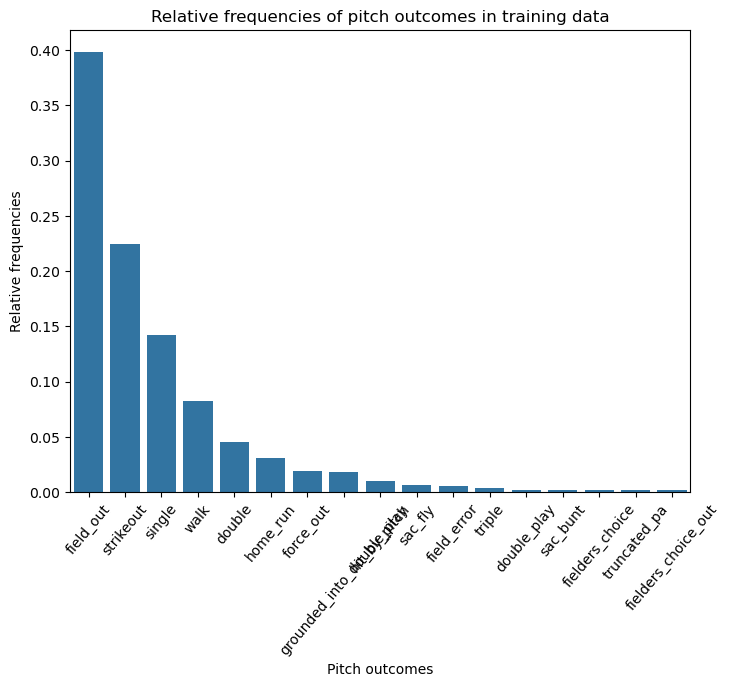

In [14]:
rel_freq = clean_train['events'].value_counts() / len(clean_train)

threshold = 0.001
# Filter out relative frequencies below the threshold
filtered_rel_freq = rel_freq[rel_freq >= threshold] 


plt.figure(figsize=(8,6))
sns.barplot(x=filtered_rel_freq.index, y=filtered_rel_freq.values)
plt.title('Relative frequencies of pitch outcomes in training data')
plt.xlabel('Pitch outcomes')
plt.ylabel('Relative frequencies')
plt.xticks(rotation=50)
plt.show()

Filter out rare pitch outcomes from training, validation, and testing data, and make sure that these three data sets cover all remaining pitch outcomes.

In [15]:
# Set pitch outcomes we will work with
pitch_outcomes = [
    'field_out',
    'strikeout',
    'single',
    'walk',
    'double',
    'home_run',
    'force_out',
    'grounded_into_double_play',
    'hit_by_pitch',
    'sac_fly',
    'triple'
]

In [16]:
# Make sure training, validation, and testing data contain all possible pitch outcomes before filtering
print(
    set(pitch_outcomes) <= set(clean_train['events'].unique()),
    set(pitch_outcomes) <= set(clean_val['events'].unique()),
    set(pitch_outcomes) <= set(clean_test['events'].unique())
)

True True True


In [17]:
# Filter out events not contained in pitch_outcomes
filtered_clean_train = clean_train[clean_train['events'].isin(pitch_outcomes)].copy()
filtered_clean_val = clean_val[clean_val['events'].isin(pitch_outcomes)].copy()
filtered_clean_test = clean_test[clean_test['events'].isin(pitch_outcomes)].copy()

print(filtered_clean_train.shape, filtered_clean_val.shape, filtered_clean_test.shape)

# Label encode categorical features
label_encoders = {} # Dictionary of label encoders for each categorical feature
for cat_feature in categorical_features:
    all_labels = pd.concat([filtered_clean_train[cat_feature], filtered_clean_val[cat_feature], filtered_clean_test[cat_feature]], axis=0)
    
    label_encoder = LabelEncoder()
    label_encoder.fit(all_labels)
    label_encoders[cat_feature] = label_encoder

    filtered_clean_train[cat_feature] = label_encoder.transform(filtered_clean_train[cat_feature])
    filtered_clean_val[cat_feature] = label_encoder.transform(filtered_clean_val[cat_feature])
    filtered_clean_test[cat_feature] = label_encoder.transform(filtered_clean_test[cat_feature])

(60843, 28) (4795, 28) (4781, 28)


In [18]:
print(label_encoders['events'].classes_)
print(len(pitch_outcomes))
print(filtered_clean_train['events'].head())


['double' 'field_out' 'force_out' 'grounded_into_double_play'
 'hit_by_pitch' 'home_run' 'sac_fly' 'single' 'strikeout' 'triple' 'walk']
11
2298    1
1877    8
1733    1
1762    8
1543    8
Name: events, dtype: int64


Standardize the continuous features using mean and standard deviation of training features.

In [19]:
# Compute mean and standard deviation of each feature, i.e. column) in train
train_standard_scaler = StandardScaler()
std_train = filtered_clean_train.copy()

# Standardize train using mean and standard deviation of train features
std_train[continuous_features] = train_standard_scaler.fit_transform(filtered_clean_train[continuous_features])

# Standardize validation using mean and standard deviation of train features
std_val = filtered_clean_val.copy()
std_val[continuous_features] = train_standard_scaler.fit_transform(filtered_clean_val[continuous_features])

# Standardize test using mean and standard deviation of train features
std_test = filtered_clean_test.copy()
std_test[continuous_features] = train_standard_scaler.transform(filtered_clean_test[continuous_features])

In [20]:
print(std_train.head())

      events  pitcher  batter  pitch_type  game_date  at_bat_number  \
2298       1      503     565           6 2023-05-01              1   
1877       8      503     149           8 2023-05-01              2   
1733       1      503     294           8 2023-05-01              3   
1762       8      139     136           6 2023-05-01              4   
1543       8      139      26           6 2023-05-01              5   

      pitch_number  pitch_count  inning  balls  ...  release_speed  \
2298             1            1       1      0  ...       0.336725   
1877             6            7       1      1  ...      -1.148471   
1733             3           10       1      1  ...      -0.966946   
1762             9            9       1      3  ...       0.996812   
1543             4           13       1      0  ...       0.881298   

      release_pos_x  release_pos_z       vx0       vy0       vz0        ax  \
2298      -0.058142       0.536230  0.291172 -0.338440 -0.969988 -0.692510

In [22]:
print(std_train.shape, std_val.shape, std_test.shape)

(60843, 28) (4795, 28) (4781, 28)


Obtain the collection of all sliding window sequences of pitches per pitcher.

In [27]:
# Input std_data is a DataFrame of shape (number of pitches, 28 features)
# Output is 3D array of shape (number of windows per pitcher, window size, input size=28 - 3 features)
def pitch_sequences(std_data, window_size):
# Group the data by pitchers
    groups = std_data.groupby('pitcher')

    # Create sliding windows of pitches per pitcher
    pitch_sequence_list=[]
    for _, group in groups:
        # Sort pitches (note that sort_values by default is ascending sorting order, i.e. lexicographic)
        group = group.sort_values(by=sorting_features)
        
        # Remove sorting features since their only purpose is for creating sliding windows
        group = group.drop(columns=sorting_features) 
                
        for i in range(len(group) - window_size + 1):
            window = group.iloc[i:i + window_size]
            pitch_sequence_list.append(window.values)
            
    pitch_sequences = np.stack(pitch_sequence_list, axis=0)
    return(pitch_sequences)

In [28]:
train_pitch_sequences=pitch_sequences(std_train, pitch_sequence_length)
val_pitch_sequences=pitch_sequences(std_val, pitch_sequence_length)
test_pitch_sequences=pitch_sequences(std_test, pitch_sequence_length)

In [29]:
print(train_pitch_sequences.shape)
print(val_pitch_sequences.shape)
print(test_pitch_sequences.shape)

(58189, 5, 25)
(3298, 5, 25)
(3287, 5, 25)


Extract labels and setup for model training and testing. All pairs (X,y) below have the following shape: X has shape (number of sequences, pitch_sequence_length-1, input_size=num_features=25) and y has shape (number of sequences,).

In [ ]:
# Training, validation, and testing arrays
X_train = train_pitch_sequences[:, :-1, :].astype('float32') # Remove the last pitch sequence
y_train = train_pitch_sequences[:, -1, 0].astype(int) # For every pitch sequence, take the event of the last pitch data

X_val = val_pitch_sequences[:, :-1, :].astype('float32')
y_val = val_pitch_sequences[:, -1, 0].astype(int)

X_test = test_pitch_sequences[:, :-1, :].astype('float32')
y_test = test_pitch_sequences[:, -1, 0].astype(int)


In [32]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(58189, 4, 25) (58189,)
(3298, 4, 25) (3298,)
(3287, 4, 25) (3287,)


Export data.

In [37]:
np.save('X_train.npy', X_train)
np.save('y_train.npy', y_train)

np.save('X_val.npy', X_val)
np.save('y_val.npy', y_val)

np.save('X_test.npy', X_test)
np.save('y_test.npy', y_test)